<a href="https://colab.research.google.com/github/BrMrtn/GoogleColab/blob/main/MI/BSc_MI_labor_7_Ensemble_learning_HU_student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

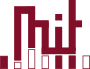 Mesterséges Intelligencia és Rendszertervezés Tanszék, ©2024. BME-MIT, Vetró Mihály, Dr. Hullám Gábor  
# **VIMIAC16 - Mesterséges Intelligencia**
## 2024. Őszi félév
## **7. Laborgyakorlat**


# **Együttes tanulás**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## **1. Motiváció**

Felügyelt tanulásnál egy konkrét feladat megoldása során az esetek túlnyomó többségében *egyetlen prediktív modellt* alkalmazunk, amely modell a probléma jellegétől (pl. mit és mi alapján szeretnénk prediktálni) és gyakorlati aspektusoktól (pl. mekkora mennyiségű és mennyire zajos adat áll rendelkezésünkre) függően lehet döntési fa, logisztikus regresszió, neurális háló, stb...

Felmerülhet a kérdés azonban, hogy lehetséges-e az előrejelzés pontosságát és megbízhatóságát javítani azáltal, hogy egyetlen modell helyett *több, különböző modell* predikciójának együttesét (pl. átlagát vagy egyéb aggregált eredményét) használjuk fel. Azt a folyamatot, amely során ugyanazon (vagy nagyon hasonló) probléma megoldására több, különböző modellt készítünk, majd ezen modellek predikcióját aggregáljuk a végleges kimenet előállításához, **együttes tanulásnak** nevezzük.

Az együttes tanulás hátrányait könnyű belátni, legfőképpen abból kiindulva, hogy egyetlen modell helyett egy több elemből álló modellhalmazt kell létrehoznunk, amely megnövekedett erőforrásigénnyel jár. Más szempontból azonban az együttes tanulás eredményéül előálló modellhalmaz aggregált prediktív teljesítménye rendszerint felülmúlja az azt alkotó modellek egyéni teljesítményét és általánosítóképességét egyaránt.

> Utóbbi tényt könnyű belátni egy valós példán keresztül: mint ahogyan több empirikus eredmény is bizonyította, egyes emberek becslési képessége az egyéni torzítás (vagy szakszóval élve: "bias") okán rendszerint pontatlan. Ez nyilvánvalóvá válik akkor, ha például megkérünk valakit, hogy becsülje meg pusztán ránézésre, hogy hány darab üveggolyó van egy áttetsző edényben, ekkor ugyanis a becslések többsége jelentősen eltérő lesz a valós számtól. Viszont, hogyha megfelelően sok ember becslését kiátlagoljuk, az így keletkező eredmény erősen közelíteni fogja a valós számot. Ennek legfőbb oka az, hogy az egyes becslések hibája (feltehetően) egymástól független, az ilyen jellegű hiba pedig több kísérlet eredményének aggregálásával csökkenthető.

## **2. Bagging és véletlen erdők**

Az együttes tanulás megvalósításának egyik legalapvetőbb módja a **Bagging**, amely — kissé leegyszerűsítve — az alábbi lépésekből áll:

1. Vegyünk kiindulásul egy $N$ rekordból és $K$ változóból álló adathalmazt.
2. Válasszuk ki egyenletes eloszlás szerint a változók $k \in K$ valódi részhalmazát (ezek a $K*N$ méretű adatmátrix oszlopai), majd visszahelyezéses mintavételezéssel (**Bootstrapping**) egy $N$ méretű rekordhalmazt a kiválasztott változókra.
3. Illesszünk egy modellt az így kapott adathalmazra.
4. Ismételjük a **2.** és **3.** lépéseket, amíg egy előre meghatározott számú modellt nem kapunk.
5. (**Aggregation**) Az így kapott modellhalmaz új mintára adott predikcióját osztályozás esetén többségi döntéssel, regresszió esetén átlagolással állapítjuk meg.

> Vegyük észre, hogy a **2.** lépésben (**Bootstrapping**) mintavételezéssel kialakított adathalmazban a változók és minták csak egy részhalmaza szerepel, illetve egy minta többször is szerepelhet a visszahelyezéses mintavételezés miatt. Ez a lépés különösen fontos, mivel így biztosítható, hogy a determinisztikus (pl. döntési fa) és alacsony varianciájú (pl. logisztikus regresszió) tanítási folyamattal rendelkező modelltípusok esetén is heterogén modellegyüttest hozzon létre az eljárás, ugyanis minden modell az eredeti adathalmaznak különböző részhalmazain tanul.

>Megjegyzés: az eredeti Bagging algoritmus mindig a teljes változóhalmazra végezte a Bootstrap mintavételezést. Véletlen erdők esetén viszont előnyös, ha a változók halmaza is véletlenszerűen sorsolt, mivel ekkor az egyes modellek kevésbé korreláltak egymással. Ennek a technikának az általános neve *Feature Bagging*, véletlen erdőknél a Bagging részét képzi.

Az eljárás sematikus folyamatábrája egy leegyszerűsített, 3 modellt létrehozó esetben az alábbi:

<!-- ![bagging_algorithm](https://share.mit.bme.hu/index.php/s/RenmdjWN8LtXNfA/download/bagging_algorithm.png) -->

<img src="https://share.mit.bme.hu/index.php/s/RenmdjWN8LtXNfA/download/bagging_algorithm.png" alt="drawing" width="900"/>

A Bagging algoritmus osztályozásra használt változatának egy lehetséges implementációja alább látható.

**Tanulmányozza a kódot, majd futtassa le a kódblokkot, ezzel definiálva az osztályt!**

In [ ]:
from sklearn.base import BaseEstimator, clone
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import mode

class BaggingClassifier:
    """
    An implementation of the Bagging algorithm for classification tasks
    for an arbitrary base estimator.

    Parameters
    ----------
    base_estimator : object
        A base estimator object implementing the `fit` and `predict` methods.
        If None, then the base estimator is a decision tree.
        Default: DecisionTreeClassifier()

    n_estimators : int
        The number of base estimators in the ensemble.
        Default: 100

    max_features : int or None
        The number of features to consider when looking for the best split.
        If None, all features are considered.
        Default: None

    random_state : int or None
        The seed for the random number generator.
        If None, the random number generator is not seeded.
        Default: None
    """
    def __init__(self, base_estimator=DecisionTreeClassifier(), n_estimators=100, max_features=None, random_state=None):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.random_state = random_state
        self.estimators_ = []
        self.features_ = []

    @staticmethod
    def bootstrap_samples_(X, y, max_features=None, random_state=None):
        """
        Bootstrap samples from the input data.
        Samples are drawn with replacement.
        If max_features is specified, only a random subset of features is considered.

        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The input data.

        y : array-like, shape (n_samples,)
            The target values.

        max_features : int or None
            The number of features to consider when looking for the best split.
            If None, all features are considered.
            Default: None

        random_state : int or None
            The seed for the random number generator.
            If None, the random number generator is not seeded.
            Default: None
        """
        # Sample the dataset with replacement sampling
        X_sampled, y_sampled = resample(X, y, replace=True, random_state=random_state)
        # Subsample the features if the max number of features is specified
        if max_features is not None and max_features < X.shape[1]:
            if random_state is not None:
                np.random.seed(random_state)
            features = np.random.choice(X.shape[1], size=max_features, replace=False)
            X_sampled = X_sampled[:, features]
            # Return the feature indices along the subsampled data
            return X_sampled, y_sampled, features
        return X_sampled, y_sampled

    def fit(self, X, y):
        """
        Fit the model to the input data.

        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The input data.

        y : array-like, shape (n_samples,)
            The target values.
        """
        self.estimators_, self.features_ = [], []

        # Produce the specified number of estimators
        for i in range(self.n_estimators):
            # Initialize a local version of the random state, if specified.
            # Otherwise the bootstrapped samples would be the same for every model when the random state is specified.
            if self.random_state is not None:
                local_random_state = self.random_state * (i + 1) * self.n_estimators
            else:
                local_random_state = None

            if self.max_features is not None and self.max_features < X.shape[1]:
                # Sample the dataset with replacement and the specified number of features
                X_sampled, y_sampled, features = self.bootstrap_samples_(X, y, max_features=self.max_features,
                                                                         random_state=local_random_state)
                self.features_.append(features)
            else:
                # Sample the dataset with replacement if the number of features is not specified
                X_sampled, y_sampled = self.bootstrap_samples_(X, y, random_state=local_random_state)

            # Train a copy of the base estimator on the sampled data
            estimator = clone(self.base_estimator).fit(X_sampled, y_sampled)
            self.estimators_.append(estimator)

        return self

    def predict(self, X):
        """
        Predict the class labels for the input data.

        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The input data.
        """
        if self.max_features is not None and self.max_features < X.shape[1]:
            # Predict on the feature subset used for each estimator
            predictions = np.array([estimator.predict(X[:, features]) for estimator, features in zip(self.estimators_, self.features_)])
        else:
            # Predict on the entire feature set for each estimator
            predictions = np.array([estimator.predict(X) for estimator in self.estimators_])
        # Return the average predicted value for every input sample
        return mode(predictions, axis=0)[0]

Vegyük észre, hogy a fenti osztályban a bootstrapping lépéshez külön statikus függvény tartozik (`bootstrap_samples_`), az aggregációt pedig a `predict` függvény végzi azáltal, hogy visszaadja az egyes modellek predikcióinak a móduszát (`mode` függvény), amely a többségi szavazással ekvivalens.

A módszer teszteléséhez ezt követően hozzunk létre egy mesterségesen kialakított adathalmazt, majd osszuk azt tanító- és teszthalmazra az alábbi kódblokk segítségével:

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Create a dummy classification problem
X, y = make_classification(n_samples=1000, n_features=20,
                           n_informative=16, n_redundant=0,
                           flip_y=0.01, n_clusters_per_class=2,
                           hypercube=True, class_sep=1.,
                           random_state=42)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Az így keletkező adathalmaz véletlenszerűen generált mintákból áll, amelyek adott számú, normál eloszlású klasztert alkotnak az n-dimenziós térben minden osztályhoz. További információval az `sklearn` csomag [`make_classification`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) függvényének dokumentációja szolál.

A fenti beállítások mellett egy összesen 1000 mintából és 20 folytonos értékű változóból álló adathalmaz áll elő, amelyet egy 800 mintás tanító- és 200 mintás teszt részhalmazra osztottunk. Ezek méretét az alábbi módon tudjuk ellenőrízni:

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 20), (200, 20), (800,), (200,))

Ezt követően definiáljuk az alábbi függvényt, amely elvégzi egy előre definiált prediktor tanítását a generált adathalmazon, majd visszaadja a betanított modell teszthalmazon mért pontosságát:

In [ ]:
from sklearn.metrics import accuracy_score

def evaluate_classifier(classifier, runs=10):
    accuracies_local = []
    for _ in range(runs):
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies_local.append(accuracy)
    return np.mean(accuracies_local)

Mivel a tanítás folyamata (a bootstrapping miatt) nemdeterminisztikus, a fenti kiértékelő függvény többször megismétli azt, és a pontosságok átlagát adja vissza, így a kapott pontosságérték bizonytalansága alacsonyabb.

Végül inicializáljuk a Bagging osztályozót az alábbi módon, és figyeljük meg, hogy milyen pontosságot ér el a mesterséges adathalmazon:

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Create a BaggingClassifier with Decision Trees as base estimators
bagging_model = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                                  n_estimators=20,
                                  max_features=int(np.sqrt(X.shape[1])))

accuracy = evaluate_classifier(bagging_model, runs=10)
print(f"Bagging Classifier Accuracy (Decision Tree): {accuracy:.3f}")

Bagging Classifier Accuracy (Decision Tree): 0.770


A fenti példában egy korlátozott maximális mélységű döntési fát (`base_estimator=DecisionTreeClassifier(max_depth=3)`) adtunk meg alapmodellként, amelyből 20 példányt (`n_estimators=20`) létrehozva alkottunk modellegyüttest. Ezen felül specifikáltuk azt is, hogy az egyes modellekhez tartozó, Bootstrapping eljárással kiválasztott minták a teljes változóhalmaz méretének négyzetgyökével azonos számú változót tartalmaznak (egészre kerekítve: `max_features=int(np.sqrt(X.shape[1]))`). Az alapmodell kiválasztása itt nem véletlen, ugyanis a széles körben ismert [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) algoritmus működése is a Bagging módszeren alapul, döntési fa alapmodellel. Fontos azonban, hogy a Bagging algoritmus paraméterei (az alapmodellt is beleértve) tetszőlegesen megválaszthatóak.

**Az alábbi kódblokkban a fentihez hasonló módon definiáljon, majd értékeljen ki egy Bagging osztályozót, eltérő paraméterekkel!**

1. **Figyelje meg a döntési fa mélységének, illetve a modellek számának hatását a pontosságra!**
2. **Próbáljon ki egy eltérő osztályozót is alapmodellként!**

> Tipp: alapmodellt érdemes az alábbi, `sklearn` csomagban definiált osztályozók közül választani:
1. [Support-Vector Machine](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) (RBF kernellel ajánlott)
2. [Naive Bayes](https://scikit-learn.org/dev//modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB)
3. [K-Nearest Neighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
4. [Gaussian Process](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessClassifier.html#sklearn.gaussian_process.GaussianProcessClassifier)

In [ ]:
################################################################################
# TODO: create and evaluate a BaggingClassifier with different parameters!
# bagging_model = ...
################################################################################

bagging_model = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                                  n_estimators=20,
                                  max_features=int(np.sqrt(X.shape[1])))

accuracy = evaluate_classifier(bagging_model, runs=10)
print(f"Bagging Classifier Accuracy (Decision Tree): {accuracy:.3f}")

Bagging Classifier Accuracy (Decision Tree): 0.793


In [ ]:
################################################################################
# TODO: create and evaluate a BaggingClassifier with a different baseline model!
# bagging_model = ...
################################################################################

accuracy = evaluate_classifier(bagging_model, runs=10)
print(f"Bagging Classifier Accuracy (other baseline): {accuracy:.3f}")

Bagging Classifier Accuracy (other baseline): 0.774


## **3. Boosting**

A Bagging algoritmus áttekintése során észrevehettük, hogy az egyes modellek egymástól teljesen független módon, véletlenszerűen kiválasztott minta alapján lettek tanítva. Ennek persze előnye, hogy az egyes modellek létrehozása párhuzamosítható, nagy hátránya viszont, hogy viszonylag nagy számú modellre van szükség ahhoz, hogy az aggregált predikció pontossága jelentősen jobb legyen az egyes modellekénél.

Ez utóbbi problémára kínál megoldást a **Boosting** algoritmusok családja. Az ide tartozó módszerek szekvenciálisan adnak hozzá újabb modelleket a modellegyütteshez úgy, hogy minden hozzáadott modell valamilyen módon "tanul" a már elkészült modellek gyengeségeiből.

Az egyik legkorábbi Boosting algoritmus az Adaptive Boosting (röviden **AdaBoost**), amelynek lényege, hogy minden modell tanítása során nagyobb súlyt kapnak azok a tanítópéldák, amelyekre a korábbi modellek hibás predikciót adtak, ezáltal az újonnan létrehozott modell azokon a mintákon jobban fog teljesíteni.

 Az AdaBoost módszer az alábbi lépésekből áll:
1. Kiindulásként határozzunk meg uniform módon egy súlyértéket minden, az adathalmazban található rekordhoz.
2. Tanítsunk be egy modellt a pillanatnyi súlyokkal.
3. Növeljük azoknak a mintáknak a súlyát, amelyekre a legújabb modell hibás predikciót adott, majd normáljuk a módosított súlyvektort.
4. Ismételjük a 2. lépéstől, amíg előre megadott számú modellt nem kapunk.
5. A modellegyüttes új mintákra adott predikcióját úgy kapjuk, hogy az egyes modellek kimenetét súlyozott módon aggregáljuk. Az aggregáció során az egyes modellek súlya annál nagyobb, minél jobb prediktív teljesítményt adtak a tanítóhalmazon.

> Az AdaBoost algoritmus (és általánosan a Boosting módszerek) iteratív módon javítják minden lépésben a meglévő modellhalmaz hibáit, felgyorsítva ezzel a folyamat konvergenciáját. Emiatt jellemzően hasonlóan jó prediktív teljesítmény eléréséhez kevesebb modell is elegendő ezen módszercsalád alkalmazásakor a Bagging algoritmushoz viszonyítva.

Az AdaBoost algoritmus sematikus folyamatábrája 3 modell esetén az alábbi:
<!-- ![adaboost_algorithm_simplified](https://share.mit.bme.hu/index.php/s/bW9FgHTr3xJpQdm/download/boosting_algorithm_simplified.png) -->

<img src="https://share.mit.bme.hu/index.php/s/bW9FgHTr3xJpQdm/download/boosting_algorithm_simplified.png" alt="drawing" width="700"/>

Ahogy a fenti ábrán is látszik, minden modell tanítása az előző modell hibájától függ, emiatt az egyes modellek létrehozása nem párhuzamosítható, csak szekvenciális módon történhet.

Az AdaBoost algoritmusnak több implementációja is létezik, mi a továbbiakban az `sklearn` csomagban foglalt változatot fogjuk használni. Gyakorlati szempontból az AdaBoost osztályozó példányosítása és használata a fent implementált Bagging módszerhez hasonló módon történik:

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

boosted_model_dt = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3),
                                      n_estimators=20,
                                      algorithm="SAMME")

accuracy = evaluate_classifier(boosted_model_dt, runs=10)
print(f"Boosted Classifier Accuracy (Decision Tree): {accuracy:.3f}")

Boosted Classifier Accuracy (Decision Tree): 0.840


Érdemes továbbá összehasonlítani, hogy az AdaBoost hogyan teljesít a Bagging algoritmussal szemben különböző méretű modellegyüttesek mellett. Ehhez futtassuk le a tanítást és a kiértékelést különböző modellszámokra, majd ábrázoljuk az eredményt az alábbi kódblokk segítségével:

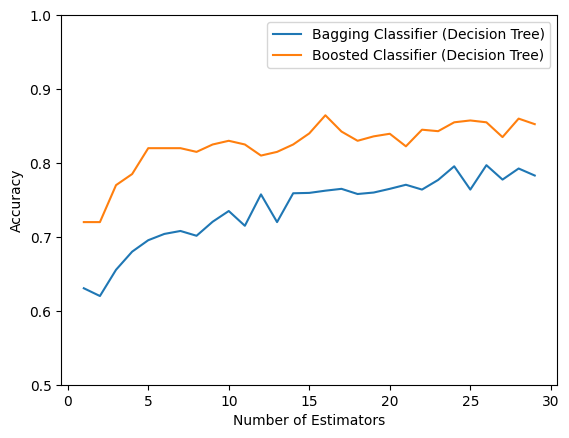

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

accuracy_values_bagging = []
accuracy_values_boosting = []

for n_estimators in range(1, 30, 1):
    bagging_model_dt = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                                         n_estimators=n_estimators,
                                         max_features=int(np.sqrt(X.shape[1])))
    accuracy_values_bagging.append(evaluate_classifier(bagging_model_dt, runs=10))

    boosted_model_dt = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3),
                                          n_estimators=n_estimators,
                                          algorithm="SAMME")
    accuracy_values_boosting.append(evaluate_classifier(boosted_model_dt, runs=10))

plt.plot(range(1, 30, 1), accuracy_values_bagging, label="Bagging Classifier (Decision Tree)")
plt.plot(range(1, 30, 1), accuracy_values_boosting, label="Boosted Classifier (Decision Tree)")
plt.xlabel("Number of Estimators")
plt.ylabel("Accuracy")
plt.ylim((0.5, 1.))
plt.legend()
plt.show();

***
**Meglátása szerint melyik módszer teljesített jobban azonos alapmodellek és modellegyüttes-méret mellett?**

{válasz}

***

**Az eredmények alapján a két módszer prediktív teljesítménye milyen mértékben növekszik a modellek számával együtt? Lát különbséget a módszerek között ebben a tekintetben?**

{válasz}

***

Végül érdemes megemlíteni, hogy több, az AdaBoost-nál modernebb Boosting algoritmus is létezik, amelyek közül talán a gradiens alapú módszerek a legismertebbek. Ezekre jó példa az `sklearn`-ben implementált [`GradientBoostingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html), illetve a külön csomagként létező [Extreme Gradient Boosting](https://xgboost.readthedocs.io/en/stable/).

## **4. Stacking**

Az eddigiekben alapvetésként feltételeztük, hogy a modellegyüttes minden tagja ugyanazon modellcsaládból (pl. döntésifa, SVM, stb...) kerül ki. Ez azonban nem feltétlen szükségszerű, egy modellegyüttes ugyanis tetszőleges típusú osztályozókból (vagy regresszorokból) is állhat egészen addig, amíg azok ugyanazon osztályozási (vagy regressziós) problémára kínálnak megoldást. Azt az általános esetet, amikor egy modellegyüttes eltérő modellcsaládból származó becslőkből tevődik össze, **Stacking**-nek nevezzük.

A megvalósítás az eddigiekhez viszonyítva egyszerűbb: `sklearn` segítségével inicializálunk néhány egyéni osztályozót, majd azokból egy modellegyüttest ([`VotingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html)). Az így létrejövő becslőt egy modellként tanítjuk és értékeljük ki.

Mindezt az alábbi kódblokk futtatásával tehetjük meg a már korábban legenerált mesterséges adathalmazon:

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

# Create a VotingClassifier with multiple base estimators
stacking_model = VotingClassifier(estimators=[
    ('decision_tree', DecisionTreeClassifier(max_depth=3)),
    ('svm', SVC(kernel='rbf')),
    ('naive_bayes', GaussianNB()),
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('gaussian_process', GaussianProcessClassifier())
], voting='hard')

accuracy = evaluate_classifier(stacking_model, runs=10)

print(f"Stacking Classifier Accuracy: {accuracy:.3f}")

Stacking Classifier Accuracy: 0.955


A megvalósítás során 5 darab modellből állítottuk össze a modellegyüttest, amely modellek mindegyike drasztikusan eltérő módon oldja meg az osztályozási problémát. Erről részletesebb leírással az egyes modelleket megvalósító osztályok dokumentációja szolgál:

1. [Decision Tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
2. [Support-Vector Machine](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
3. [Naive Bayes](https://scikit-learn.org/dev//modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB)
4. [K-Nearest Neighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
5. [Gaussian Process](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessClassifier.html#sklearn.gaussian_process.GaussianProcessClassifier)

> Érdemes megfigyelni, hogy a Stacking eljárás segítségével létrehozott, 5 eltérő modellt magába foglaló osztályozó lényegesen jobb teljesítményt ért el, mint a korábbi, egyetlen modelltípus példányait tartalmazó modellegyüttesek. Ez azt jelenti, hogy a mesterségesen generált adathalmaz által definiált osztályozási probléma megoldása során jelentős előnyt jelent a modellek diverzitása, vagy más szavakkal élve: ebben az esetben az eltérő megközelítést képviselő modellek predikciói jól kiegészítik egymást. Egy harmadik (és talán legáltalánosabb) mefogalmazása ennek a jelenségnek úgy hangzik, hogy a modellegyüttesben lévő egyes modellek jellemzően eltérő bemeneteken tévednek, így az általuk hozott egyszerű többségi döntés megbízhatóbb, mint az egyes modellek predikciója. Fontos megjegyezni azonban, hogy ez nem feltétlenül igaz minden osztályozási (vagy éppen regressziós) problémára, így a különböző megközelítések egyéni vizsgálata továbbra is fontos. Például előfordulhat, hogy a modellek többsége különösen rosszul teljesít az adathalmazon, így a modellegyüttes teljesítménye akár rosszabb is lehet néhány egyéni modell teljesítményénél.

## **5. Valós adathalmaz**

A továbbiakban egy, az eddig használt, mesterségesen generált adathalmazhoz hasonló formátumú, ám valós adathalmazon fogjuk kipróbálni az eddig megismert módszereket.

Ehhez először állítsuk alapállapotba a Colab környezetet, majd töltsük be a használandó adathalmazt:

In [ ]:
%reset -f
import numpy as np
import pandas as pd

spambase_df = pd.read_csv("https://share.mit.bme.hu/index.php/s/wgc46gCHRb7bPdF/download/spambase.csv")

spambase_df

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,Class
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.0,0.778,0.000,0.00,3.756,61,278,1
1,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.010,0.143,0.0,0.276,0.184,0.01,9.821,485,2259,1
2,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.000,0.137,0.0,0.137,0.000,0.00,3.537,40,191,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.000,0.135,0.0,0.135,0.000,0.00,3.537,40,191,1
4,0.00,0.00,0.00,0.0,1.85,0.00,0.00,1.85,0.00,0.00,...,0.000,0.223,0.0,0.000,0.000,0.00,3.000,15,54,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3676,0.00,0.00,1.19,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.0,0.000,0.000,0.00,1.000,1,24,0
3677,0.31,0.00,0.62,0.0,0.00,0.31,0.00,0.00,0.00,0.00,...,0.000,0.232,0.0,0.000,0.000,0.00,1.142,3,88,0
3678,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.0,0.353,0.000,0.00,1.555,4,14,0
3679,0.30,0.00,0.30,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.102,0.718,0.0,0.000,0.000,0.00,1.404,6,118,0


A fenti adatbázis összesen 57 darab folytonos értékű változót, és egy bináris célváltozót tartalmaz. A bemeneti változók email-ekből kinyert leíró statisztikák, amelyek egyes szavak és karakterek relatív előfordulási gyakoriságát (százalékosan, a `word_freq_*` és `char_freq_*` kezdetű változók), illetve a csupa nagybetűs karaktersorozatok átlagos hosszát, a leghosszabb ilyen sorozat hosszát és a nagybetűs karakterek össz-mennyiségét adják meg. A célváltozó az adathalmaz utolsó oszlopában látható `Class`, amely megadja, hogy az eredeti email spam-nek számít-e (`Class=1`), vagy nem (`Class=0`).

Ezt követően a tanításra való előkészítés végett bontsuk fel az adathalmazt tanító- és teszt részhalmazokra:

In [ ]:
from sklearn.model_selection import train_test_split

X = spambase_df.drop("Class", axis=1).values
y = spambase_df["Class"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

## **6. Feladatbeadás**

A feladat egy spam-osztályozó készítése a fent ismertetett modellegyüttesek és a `spambase` adathalmaz felhasználásával.

**Ezt a `spam_predictor.py` fájl alább látható szkeletonjának módosításával valósítsa meg!**

A szkeletonban található `predict` függvényt módosítsa úgy, hogy az hozzon létre egy tetszőleges típusú modellegyüttest, tanítsa be a paraméterként kapott tanítóadaton (`X_train` és `y_train`) majd térjen vissza a szintén paraméterként kapott teszthalmazra (`X_test`) adott predikciókkal!

> Tipp: A Moodle kiértékelő szerverén telepítve van az `sklearn` könyvtár, így érdemes az abban adott adott [modellegyüttes-módszereket](https://scikit-learn.org/stable/api/sklearn.ensemble.html), és [osztályozókat](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html) használni a feladat megoldásához.

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

def predict(X_train, y_train, X_test):
    ######################################################
    # Create and fit an ensemble-based classifier here!
    # ensemble_model = ...
    ######################################################

    ensemble_model = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3),
                                        n_estimators=20,
                                        algorithm="SAMME")
    ensemble_model.fit(X_train, y_train)

    #ensemble_model = RandomForestClassifier(n_estimators=100, random_state=42)
    #ensemble_model.fit(X_train, y_train)

    return ensemble_model.predict(X_test)

Ezt követően ellenőrzésképpen vizsgáljuk meg, hogy a fent definiált `predict` függvény milyen pontosságot ér el a teszthalmazon:

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = predict(X_train, y_train, X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Ensemble Classifier Accuracy: {accuracy:.3f}")

Ensemble Classifier Accuracy: 0.943


A laborhoz tartozó Moodle-feladat akkor számít teljesítettnek, hogyha a `spambase` adatbázis egy különálló teszthalmazán legalább `93%`-os pontosságértéket sikerül elérni. A Moodle rendszerben használt teszthalmaz **nem azonos az itt látott teszthalmazzal**, de ugyanazokat a változókat tartalmazza.

> **Fontos:** A feladat beadásánál figyeljen oda arra, hogy a beadott fájl neve `spam_predictor.py` legyen, és a fent látható szignatúrával azonos módon legyen benne definiálva a `predict` függvény!

Beadás:
